In [9]:
import os
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import autosklearn.regression as autoreg
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import sys
sys.path.insert(1, '../')
from functions import *
from plot import *

In [23]:
from sklearn.model_selection import BaseCrossValidator
class BlockingTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
def quantile_loss(solution, prediction, quantile):
    e = solution - prediction
    return np.mean(np.maximum(e*quantile, e*(quantile - 1)))

qloss_05= make_scorer(
        name="quantile_loss_05",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.05,
    )
qloss_95= make_scorer(
        name="quantile_loss_95",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.95,
    )

qloss_10= make_scorer(
        name="quantile_loss_10",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.10,
    )

qloss_90= make_scorer(
        name="quantile_loss_90",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.90,
    )
qloss_025= make_scorer(
        name="quantile_loss_025",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=False,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.025,
    )

qloss_975= make_scorer(
        name="quantile_loss_975",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=True,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.975,
    )
qloss_5 = make_scorer(
        name="quantile_loss_5",
        score_func=quantile_loss,
        optimum=1,
        greater_is_better=True,
        needs_proba=False,
        needs_threshold=False,
        quantile=0.5,
    )

In [10]:
train = pd.read_csv("../data/train_solar.csv", index_col = 'timestamp')
test = pd.read_csv("../data/test_solar.csv", index_col = 'timestamp')

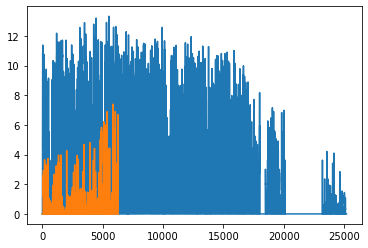

In [11]:
plt.plot(train.energy.to_numpy())
plt.plot(test.energy.to_numpy())

In [25]:
from tsfresh.feature_extraction.feature_calculators import agg_autocorrelation
agg_autocorrelation(train.energy, param=[{"f_agg":'mean', 
                                         "maxlag":300}])

[('f_agg_"mean"__maxlag_300', 0.12146818748667855)]

In [48]:
train = extract_dmhq(train)
test = extract_dmhq(test)

In [72]:
from sklearn.model_selection import train_test_split
## Shuffle by every two days
data = pd.concat([train, test],axis = 0)
data = extract_dmhq(data)
cols = ['yd']
ftrain, ttrain = feature_target_construct(data, 'energy', 300, 192, 0, 192, cols, 4,
                                          wd_on = False, d_on = False,
                                          m_on = False, h_on = False, q_on = False)
data = pd.concat([ftrain, ttrain], axis = 1)

# now define random split groups
groups = [data for _, data in data.groupby('yd1(t+0)')]
random.shuffle(groups,)

for i, df in enumerate(groups):
    data['yd1(t+0)'] = i+1
shuffled = pd.concat(groups).reset_index(drop=True)
ftrain = shuffled.iloc[:,1:201]
ttrain = shuffled.iloc[:,201:]

## split in 7/3 manner
train_X, test_X, train_Y, test_Y = train_test_split(ftrain, ttrain, train_size = 0.7, shuffle = False)

In [84]:
cols = ['cloudCover','uvIndex']
ftrain, ttrain = feature_target_construct(train, 'energy', 300, 192, 0, 192, cols, 4,
                                          wd_on = True, d_on = False,
                                          m_on = False, h_on = True, q_on = False)

ftest, ttest = feature_target_construct(test, 'energy', 300, 192, 0, 192, cols, 4, 
                                        wd_on = True, d_on = False,
                                        m_on = False, h_on = True, q_on = False)

In [85]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=10000)
rr.fit(ftrain, ttrain)
ypred = rr.predict(ftest)
yhat = rr.predict(ftrain)
get_eval(ttrain, yhat)
get_eval(ttest, ypred)

MSE: 2.126308946013635
MAE: 0.8297501067930257
r2_score: 0.731488130594475
MSE: 0.4666207923703622
MAE: 0.32541022623860955
r2_score: 0.40760059481678784


In [74]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=10000)
rr.fit(train_X, train_Y)
ypred = rr.predict(test_X)
yhat = rr.predict(train_X)
get_eval(train_Y, yhat)
get_eval(test_Y, ypred)

MSE: 2.475062580230968
MAE: 0.899218246713702
r2_score: 0.6460306821786883
MSE: 2.4443953171948505
MAE: 0.8737635435104608
r2_score: 0.6090740817967003


In [54]:
# pacf_val, conf = pacf(train.energy, nlags = 700, alpha = 0.05)
# indices = np.argwhere((np.abs(pacf_val) > 0.025))

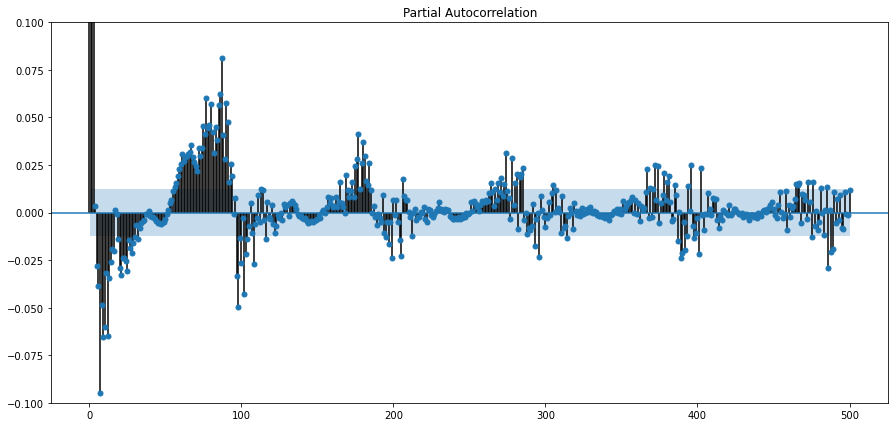

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,7))
plt.ylim(-0.1,0.1)
plot_pacf(train.energy, lags = 500, ax = ax)
plt.show()

### tsFresh featuer construction

In [7]:
train = pd.read_csv("../data/train_solar.csv", )
test = pd.read_csv("../data/test_solar.csv", )
ftrain, ttrain = tf_construct(train, 'energy', 200, 192)
ftest, ttest = tf_construct(test, 'energy', 200, 192)

In [18]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh import extract_features

# ftrain_tf = pd.DataFrame()
# for i in range(5000):
#     df_time, y = make_forecasting_frame(ftrain.iloc[i,:].to_numpy(), kind = 'time', max_timeshift=300, rolling_direction=1)
#     df_time.drop(['time','kind'],axis = 1, inplace = True)
#     df_time = df_time.loc[df_time['id'] == 'id=id,timeshift=299']
#     extracted_features = extract_features(df_time, column_id='id').dropna(axis = 1)
#     ftrain_tf = ftrain_tf.append(extracted_features)

ftest_tf = pd.DataFrame()
for i in range(ftest.shape[0]):
    df_time, y = make_forecasting_frame(ftest.iloc[i,:].to_numpy(), kind = 'time', max_timeshift=300, rolling_direction=1)
    df_time.drop(['time','kind'],axis = 1, inplace = True)
    df_time = df_time.loc[df_time['id'] == 'id=id,timeshift=299']
    extracted_features = extract_features(df_time, column_id='id').dropna(axis = 1)
    ftest_tf = ftest_tf.append(extracted_features)

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


In [20]:
ftrain_tf.to_csv("tftrain_solar300_n5000.csv", index= 'id')
ftest_tf.to_csv("tftest_solar300_p1000.csv", index= 'id')
ftrain_tf.shape, ftest_tf.shape

((4509, 758), (509, 758))

## Lag features 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, KFold
regl = autoreg.AutoSklearnRegressor(time_left_for_this_task=180000,
                                           per_run_time_limit=18000,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=50, 
                                           ensemble_nbest=25,
                                           ensemble_memory_limit=5120, 
                                           seed=219, ml_memory_limit=10092, 
                                           include_estimators=None,
                                           exclude_estimators=['gaussian_process'], 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy = TimeSeriesSplit,
                                           resampling_strategy_arguments={'folds':5,
                                                                          'shuffle': False},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 2, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


regl.fit(ftrain, ttrain)

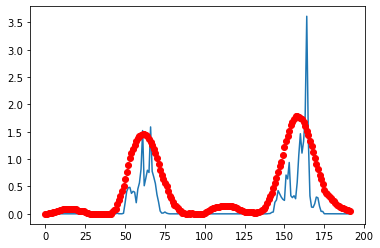

In [33]:
plt.plot(test_Y.to_numpy()[100,])
plt.plot(ypred[100,], 'ro')

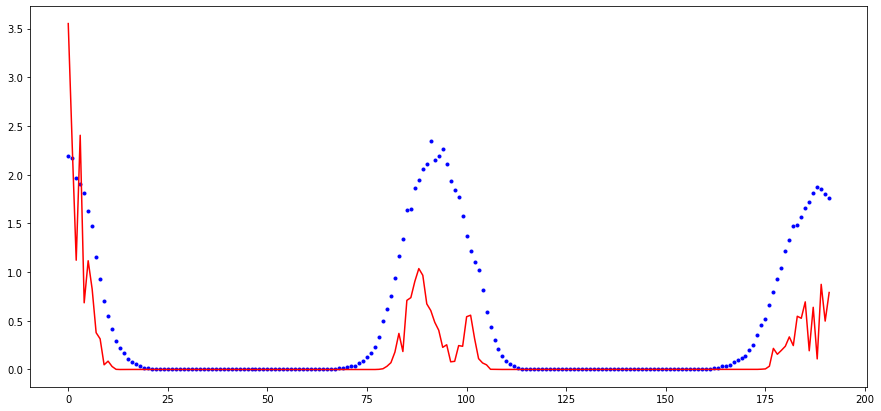

In [13]:
plt.figure(figsize=(15,7))
plt.plot(ypred[192,:], 'b.')
plt.plot(ttest.to_numpy()[192,:],'r-')

In [48]:
from pickle import dump
## pickle the model
dump(regl, open('200lag_10hr','wb'))

In [2]:
## load model
from pickle import load
with open('solar_200lag_20hr_ns', 'rb') as pickcle_file:
    model = load(pickcle_file)

In [4]:
model.__class__

autosklearn.estimators.AutoSklearnRegressor

In [11]:
%time model.refit(ftrain, ttrain)

CPU times: user 13min 51s, sys: 711 ms, total: 13min 52s
Wall time: 13min 52s


/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=5120,
                     ensemble_nbest=25, ensemble_size=50,
                     exclude_estimators=['gaussian_process'],
                     exclude_preprocessors=None, get_smac_object_callback=None,
                     include_estimators=None, include_preprocessors=None,
                     initi...
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory=None, metric=None,
                     ml_memory_limit=10092, n_jobs=4, output_folder=None,
                     per_run_time_limit=7200,
                     resampling_strategy=<class 'sklearn.model_selection._split.TimeSeriesSplit'>,
                     resampling_strategy_arguments={'folds': 5,
                                                    'shuffle': False},
          

In [9]:
model.get_models_with_weights()

[(0.5,
  SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'quantile_transformer', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_regression', 'regressor:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.04954131522076259, 'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:n_quantiles': 1170, 'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:output_distribution': 'normal', 'feature_preprocessor:extra_trees_preproc_for_regression:bootstrap': 'True', 'feature_preprocessor:extra_trees_preproc_for_regression:criterion': 'friedman_mse', 'feature_pr

In [12]:
from sklearn.pipeline import Pipeline
transform_pip = Pipeline([('data_pre', model.get_models_with_weights()[0][1][0]),
                         ('feature_pre', model.get_models_with_weights()[0][1][1])])
pftrain = transform_pip.transform(ftrain)
pftest = transform_pip.transform(ftest)
model.get_models_with_weights()[0][1][2].choice.estimator.estimators_[0].predict(pftest)


array([[1.22385633, 1.26221663, 1.1839469 , ..., 1.4087268 , 1.60676402,
        1.80979007],
       [1.22385633, 1.26221663, 1.1839469 , ..., 1.4087268 , 1.60676402,
        1.80979007],
       [3.05411041, 2.80992783, 2.76056448, ..., 0.88175362, 0.94349796,
        0.96929276],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [103]:
model.get_models_with_weights()[0][1].predict(ftrain)

array([[3.5625383e-06, 1.4985968e-05, 1.2117549e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.0070560e-03, 4.0380503e-03, 5.7796235e-03, ..., 2.0202822e-03,
        2.7615041e-03, 3.6530229e-03],
       [4.9453582e-05, 1.3990041e-04, 5.8070291e-04, ..., 0.0000000e+00,
        1.8672733e-07, 2.4186989e-05],
       ...,
       [2.1470511e-01, 2.4732487e-01, 2.7353477e-01, ..., 1.6619445e-01,
        1.9030641e-01, 2.2514109e-01],
       [2.7931151e-01, 3.2100862e-01, 3.4111154e-01, ..., 2.3892874e-01,
        2.7101091e-01, 3.1314296e-01],
       [3.0238208e-01, 3.4092757e-01, 3.6255863e-01, ..., 2.5415677e-01,
        2.8857020e-01, 3.2707986e-01]], dtype=float32)

In [14]:
import sklearn.ensemble
from sklearn.pipeline import Pipeline
model_list = model.get_models_with_weights()
weight_list = []
predict_list = []
for i in range(len(model_list)):
    weight_list.append(model_list[i][0])
    prediction_list = []
    # if contain forest based estimator, construct prediction list for 
    if issubclass(type(model_list[i][1][2].choice.estimator), \
                  sklearn.ensemble._forest.BaseForest):
        for est in model_list[i][1][2].choice.estimator.estimators_:
            pip = Pipeline([('data_pre', model_list[i][1][0]),
                            ('feature_pre', model_list[i][1][1])])
            pftest = pip.transform(ftest)
            prediction_list.append(est.predict(pftest))
        predict_list.append(prediction_list)
    else:
        predict_list.append(model_list[i][1].predict(ftest))
    

In [15]:
ub = 0
lb = 0
for i, weight in enumerate(weight_list):
    # check if the prediction is list, then construct ci
    if issubclass(type(predict_list[i]), list):
        ub += weight * np.quantile(predict_list[i], 0.9, axis = 0)[0,:]
        lb += weight * np.quantile(predict_list[i], 0.1, axis = 0)[0,:]
    else:
        ub += weight*predict_list[i]
        lb += weight*predict_list[i]


In [16]:
ypred = model.predict(ftest)

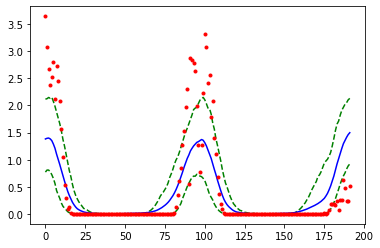

In [17]:
plt.plot(ub, 'g--')
plt.plot(lb, 'g--')
plt.plot(ypred[0,:], 'b-')
plt.plot(ttest.to_numpy()[0,:],'r.')

## lag + tsfresh

In [69]:
ftrain_lts = np.concatenate([ftrain.to_numpy(), ftrain_tf.to_numpy()], axis = 1)
ftest_lts = np.concatenate([ftest.to_numpy(), ftest_tf.to_numpy()], axis = 1)

In [ ]:
reg_lts = autoreg.AutoSklearnRegressor(time_left_for_this_task=1000,
                                           per_run_time_limit=300,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=0, 
                                           ensemble_nbest=0,
                                           ensemble_memory_limit=5120, 
                                           seed=921, ml_memory_limit=6144, 
                                           include_estimators=None,
                                           exclude_estimators='gaussian_process', 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy=TimeSeriesSplit,
                                           resampling_strategy_arguments={'folds': 5},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 6, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


reg_lts.fit(ftrain_lts, ttrain)

In [71]:
reg_lts.cv_results_

{'mean_test_score': array([ 0.        ,  0.21177564,  0.        ,  0.        ,  0.        ,
        -0.30709209, -0.02234649, -0.48586259,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.02585408,
         0.        ,  0.        ,  0.09035615,  0.        ,  0.33210265,
         0.        ,  0.        ,  0.2766813 ,  0.0669718 ,  0.        ,
         0.        ,  0.08851303,  0.00925268,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.29825572,  0.0669718 ,  0.        ,  0.        ,  0.        ,
         0.        ]),
 'mean_fit_time': array([3.00120686e+02, 3.37824309e+01, 2.28317022e-01, 3.00091033e+02,
        1.37731240e+01, 5.53160787e+00, 2.37721062e+00, 4.46084619e+00,
        2.20927954e-01, 3.00126973e+02, 1.21481569e+01, 1.34432335e+01,
        3.00078530e+02, 3.00068238e+02, 3.00122437e+02, 3.00086346e+

In [72]:
print(reg_lts.get_models_with_weights())
print(reg_lts.sprint_statistics())

[(0.46, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'regressor:__choice__': 'k_nearest_neighbors', 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.9028878306178143, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.10562216348863988, 'feature_preprocessor:feature_agglomeration:affinity': 'manhattan', 'feature_preprocessor:feature_agglomeration:linkage': 'complete', 'feature_preprocessor:feature_agglomeration:n_clusters': 388, 'feature_preprocessor:feature_agglomeration:pooling_func': 'max', 'regressor:k_nearest_neighbors:n_neighbors': 71, 'regresso

In [73]:
reg_lts.refit(ftrain_lts, ttrain)

/home/charles/anaconda3/envs/autoskdev/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=5120,
                     ensemble_nbest=20, ensemble_size=50,
                     exclude_estimators='gaussian_process',
                     exclude_preprocessors=None, get_smac_object_callback=None,
                     include_estimators=None, include_preprocessors=None,
                     initial...
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory=None, metric=None, ml_memory_limit=6144,
                     n_jobs=6, output_folder=None, per_run_time_limit=300,
                     resampling_strategy=<class 'sklearn.model_selection._split.TimeSeriesSplit'>,
                     resampling_strategy_arguments={'folds': 5}, seed=921,
                     shared_mode=False, smac_scenario_args=None,
                     time_le

In [95]:
ypred_lts = reg_lts.predict(ftest_lts[:250,:])
yhat_lts = reg_lts.predict(ftrain_lts)
get_eval(ttest.iloc[:250,:], ypred_lts)
get_eval(ttrain, yhat_lts)

MSE: 606408.0119964308
MAE: 308.69294544392847
r2_score: 0.527026683437762
MSE: 4557.053207206985
MAE: 23.82313953311414
r2_score: 0.9927859197739062


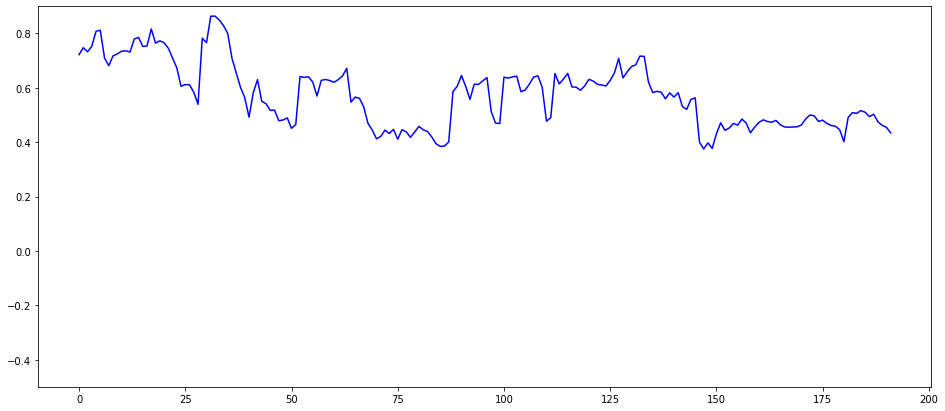

In [76]:
from sklearn.metrics import r2_score

r2c_list_test = []
for i in range(192):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy().reshape(1,-1))
    p_y = np.transpose(ypred_lts[i,:].reshape(1,-1))
    r2 = r2_score(o_y, p_y)
    r2c_list_test.append(r2)
fig = plt.figure(figsize = (16, 7))
plt.ylim(-0.5,0.9)
plt.plot(r2c_list_test, 'b-')

In [ ]:
plot_conf_std_static(ttrain, yhat, ttest, ypred_t, 200,1.96)

In [ ]:
verf_ci_std_static(1.96, ttrain, yhat, ttest.iloc[:800,:], ypred_t[:800,:])

In [ ]:
plot_conf_static(ttrain, yhat, ttest, ypred_t, 1000, 0.05)

In [ ]:
verf_ci_static(0.05, ttrain, yhat, ttest, ypred_t)